#Initialization

###Imports

In [28]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
  raise SystemError("GPU device not found")
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


###Setup input and global variables

In [29]:
configurations = []
classifiers = []
histories = []

In [30]:
config = (32, 2, 32)
configurations.append(config)

config = (64, 2, 32)
configurations.append(config)

config = (128, 2, 32)
configurations.append(config)

config = (256, 2, 32)
configurations.append(config)

config = (512, 2, 32)
configurations.append(config)

###Read Datasets

In [31]:
def parse_dataset(filepath):
    """ function used to parse the data of a dataset """

    # open the dataset
    with open(filepath, "rb") as dataset:
        # read the magic number and the number of images
        magic_number, number_of_images = struct.unpack(">II", dataset.read(8))
        # read the number of rows and number of columns per image
        rows, columns = struct.unpack(">II", dataset.read(8))
        # now read the rest of the file using numpy.fromfile()
        images = np.fromfile(dataset, dtype=np.dtype(np.uint8).newbyteorder(">"))
        # reshape so that the final shape is (number_of_images, rows, columns)
        images = images.reshape((number_of_images, rows, columns))

    # return the images
    return images


def parse_labelset(filepath):
    """ function used to parse the data of a labelset """

    # open the file
    with open(filepath, "rb") as labelset:
        # read the magic number and the number of labels
        magic_number, number_of_labels = struct.unpack(">II", labelset.read(8))
        # now read the rest of the file using numpy.fromfile()
        labels = np.fromfile(labelset, dtype=np.dtype(np.uint8).newbyteorder(">"))

    # return the labels
    return labels

In [32]:
# EDIT THE PATHS OF THE DATASETS HERE
train_images_path = os.path.join(".", "drive", "My Drive", "Uni", "Project", "training.dat")
train_labels_path = os.path.join(".", "drive", "My Drive", "Uni", "Project", "training_labels.dat")

test_images_path = os.path.join(".", "drive", "My Drive", "Uni", "Project", "test.dat")
test_labels_path = os.path.join(".", "drive", "My Drive", "Uni", "Project", "test_labels.dat")


# LOAD THE DATASETS HERE
X = parse_dataset(train_images_path)
Y = parse_labelset(train_labels_path)
lb = LabelBinarizer()
Y = lb.fit_transform(Y)

X_test = parse_dataset(test_images_path)
Y_test = parse_labelset(test_labels_path)
Y_test = lb.transform(Y_test)
# GET USEFUL VARIABLES
rows = X.shape[1]
columns = X.shape[2]

X = X.reshape(-1, rows, columns, 1)
X_test = X_test.reshape(-1, rows, columns, 1)
# normalize
X = X / 255.
X_test = X_test / 255.

# GET VALIDATION DATASET FROM TRAINING SET
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=13, shuffle=True)


# PRINTS TO MAKE SURE
print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}".format(Y_train.shape))
print()
print("X_val.shape = {}".format(X_val.shape))
print("y_val.shape = {}".format(Y_val.shape))
print()
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(Y_test.shape))

X_train.shape = (51000, 28, 28, 1)
y_train.shape = (51000, 10)

X_val.shape = (9000, 28, 28, 1)
y_val.shape = (9000, 10)

X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


###Miscellaneous

In [42]:
def plot_example_images(images, label, pred):
    fig=plt.figure(figsize=(12, 9))
    columns = 3
    rows = 4
    for i in range(len(pred)):
        im = fig.add_subplot(rows, columns, i+1)
        title = "Predicted {}, Class {}".format(pred[i], label[i])
        im.title.set_text(title)
        plt.imshow(images[i], cmap='gray')
    plt.show()
    rows_pad = (conv_kernel_size[0] - 1) // 2
    columns_pad = (conv_kernel_size[1] - 1) // 2
    # return the result
    return (rows_pad, columns_pad)

  
def show_graphs(histories, configurations):
    """ Function used to plot the losses of a model, for each configuration (experiment) tried """

    # get the number of experiments performed
    experiments = len(histories)

    # get the last losses of each experiment
    train_losses = [history.history["categorical_crossentropy"][-1] for history in histories]
    val_losses = [history.history["val_categorical_crossentropy"][-1] for history in histories]

    # now fix the x labels to match every experiment
    xlabels = []
    # add a label for each configuration
    for configuration in configurations:
        # get the values for that configuration
        units, epochs, batch_size = configuration
        # define the string and append it
        xlabel = "Units: {}\nEpochs: {}\nBatch Size: {}\n".format(units, epochs, batch_size)
        xlabels.append(xlabel)

    # define the parameters of the plot
    plt.figure(figsize=(15, 10))
    plt.xticks(np.arange(experiments), xlabels)

    # plot the losses
    plt.plot(train_losses, label="Train Loss", color="mediumblue")
    plt.plot(val_losses, label="Validation Loss", color="darkred")

    # define some more parameters
    plt.xlabel("Runs")
    plt.ylabel("Losses")
    plt.legend()
    plt.show()

#Classifier Creation

###Create Classifier

In [34]:
from tensorflow.keras.models import load_model

def load_keras_model(model_path):
    """ Function used to load a model from a specific path """

    # just save the model
    return load_model(model_path)

def create_classifier(rows, columns, encoder, units):
    """
    Function that given the encoder part and the dense part of a classifier, creates a "Model"
    (Keras object) that represents a classifier.
    """

    # define the input
    input = Input(shape=(rows, columns, 1))
    x = input

    # pass the input through the encoder
    x = encoder(x)

    x = Flatten()(x)
    # pass then the result through the dense layer
    x = Dense(units=units, activation='relu')(x)
    x = Dense(units=10, activation='softmax')(x)

    # create the model and return it
    classifier = Model(input, x, name="classifier")
    return classifier

###Train

In [35]:
encoder_path = test_labels_path = os.path.join(".", "drive", "My Drive", "Uni", "Project", "encoder.h5")
encoder = load_keras_model(encoder_path)

for config in configurations:
  units, epochs, batch_size = config

  encoder.trainable = False

  classifier = create_classifier(rows, columns, encoder, units)
  print()
  classifier.summary()

  callback = ReduceLROnPlateau(monitor="val_loss", factor=1.0/2, patience=4, min_delta=0.005,
                                cooldown=0, min_lr=1e-8, verbose=1)
  # callback = EarlyStopping(monitor="val_loss")

  classifier.compile(optimizer=optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["categorical_crossentropy", "accuracy"])

  history = classifier.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                            shuffle=True, validation_data=(X_val, Y_val),
                            callbacks=[callback])

  encoder.trainable = True

  print()
  classifier.summary()

  history = classifier.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                            shuffle=True, validation_data=(X_val, Y_val),
                            callbacks=[callback])

  # save this history
  histories.append(history)
  classifiers.append(classifier)


Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 7, 7, 64)          179008    
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                100384    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                330       
Total params: 279,722
Trainable params: 100,714
Non-trainable params: 179,008
_________________________________________________________________
Epoch 1/2
1594/1594 [==============================] - 7s 4ms/step - loss: 0.2317 - categorical_crossentropy:

###Evaluate on the test-set

Configuration:  (32, 2, 32)
Test Loss:  0.088615134
Test Accuracy:  0.9733
Found  9733  correct labels
Found  267  incorrect labels
              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98       980
     Class 1       0.99      0.99      0.99      1135
     Class 2       0.99      0.96      0.97      1032
     Class 3       0.97      0.98      0.98      1010
     Class 4       0.98      0.98      0.98       982
     Class 5       0.97      0.98      0.97       892
     Class 6       0.97      0.99      0.98       958
     Class 7       0.95      0.99      0.97      1028
     Class 8       0.98      0.96      0.97       974
     Class 9       0.98      0.95      0.96      1009

   micro avg       0.98      0.97      0.97     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.98      0.97      0.97     10000
 samples avg       0.97      0.97      0.97     10000

Configuration:  (64, 2, 32)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss:  0.109436765
Test Accuracy:  0.9672
Found  9672  correct labels
Found  328  incorrect labels
              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.98       980
     Class 1       1.00      0.99      0.99      1135
     Class 2       0.99      0.96      0.98      1032
     Class 3       0.96      0.97      0.97      1010
     Class 4       0.99      0.92      0.95       982
     Class 5       0.98      0.98      0.98       892
     Class 6       0.97      0.98      0.98       958
     Class 7       0.98      0.96      0.97      1028
     Class 8       0.99      0.94      0.96       974
     Class 9       0.89      0.98      0.93      1009

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000
 samples avg       0.97      0.97      0.97     10000

Configuration:  (128, 2, 32)
Test Loss:  0.100355715
Test Accuracy:  0.9693
Found  

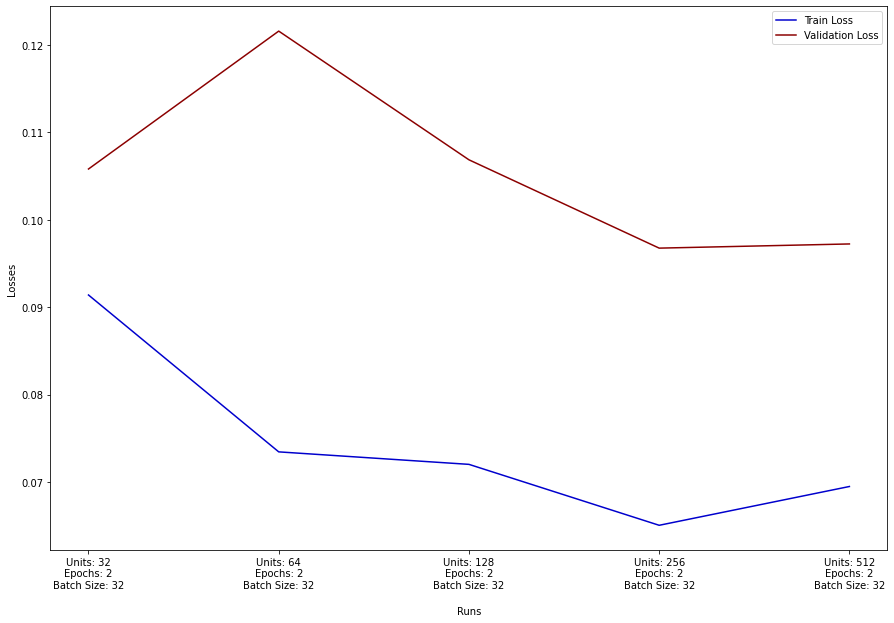

In [43]:
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import classification_report, accuracy_score

for i in range(len(configurations)):
  print("Configuration: ", configurations[i])

  Y_pred = classifiers[i].predict(X_test)

  cce = CategoricalCrossentropy()
  loss = cce(Y_test, Y_pred).numpy()
  print("Test Loss: ", loss)

  Y_pred = np.round(Y_pred, 0)
  Y_pred = Y_pred.astype(int)

  accuracy = accuracy_score(Y_test, Y_pred)
  print("Test Accuracy: ", accuracy)

  true_accuracy = accuracy_score(Y_test, Y_pred, normalize=False)
  print("Found ", true_accuracy, " correct labels")
  print("Found ", (Y_test.shape[0]-true_accuracy), " incorrect labels")

  target_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6", "Class 7", "Class 8", "Class 9"]
  report = classification_report(Y_test, Y_pred, target_names=target_names)
  print(report)


show_graphs(histories, configurations)